In [3]:
import pandas as pd
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equal_opportunity_difference
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import json
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from fairlearn.datasets import fetch_adult
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
from fairlearn.reductions import DemographicParity

In [17]:
# Display entire dataframe without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows


       FIPS  stateFIPS  countyFIPS_2d  \
0      1001          1              1   
1      1003          1              3   
2      1005          1              5   
3      1007          1              7   
4      1009          1              9   
5      1011          1             11   
6      1013          1             13   
7      1015          1             15   
8      1017          1             17   
9      1019          1             19   
10     1021          1             21   
11     1023          1             23   
12     1025          1             25   
13     1027          1             27   
14     1029          1             29   
15     1031          1             31   
16     1033          1             33   
17     1035          1             35   
18     1037          1             37   
19     1039          1             39   
20     1041          1             41   
21     1043          1             43   
22     1045          1             45   
23     1047     

In [2]:

# Load the dataset (replace 'adult.csv' with the path to your dataset)
df = pd.read_csv('covid_data_log_200922.csv')

In [5]:
df.columns

Index(['FIPS', 'stateFIPS', 'countyFIPS_2d', 'County', 'State', 'Cases',
       'Deaths', 'Poverty', 'Population', 'W_Male', 'W_Female', 'B_Male',
       'B_Female', 'H_Male', 'H_Female', 'I_Male', 'I_Female', 'A_Male',
       'A_Female', 'NH_Male', 'NH_Female', 'Risk_Index', 'Risk_Cat'],
      dtype='object')

In [6]:
df.head()

,FIPS,stateFIPS,countyFIPS_2d,County,State,Cases,Deaths,Poverty,Population,W_Male,...,H_Male,H_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Female,Risk_Index,Risk_Cat
0,1001,1,1,Autauga County,AL,10.590264,6.812345,10.916415,10.930765,10.651360,...,7.903227,7.787797,5.978886,6.100319,6.588926,6.778785,4.465908,4.317488,65.42,Above Average
1,1003,1,3,Baldwin County,AL,11.251171,6.864848,12.279579,12.315976,12.162852,...,9.734477,9.629182,7.908755,7.872455,7.756623,8.129764,5.537334,5.587249,68.39,Above Average
2,1005,1,5,Barbour County,AL,10.111517,5.043425,9.997843,10.113992,9.465448,...,7.552762,7.291656,5.652489,5.204007,4.844187,4.948760,4.276666,3.713572,97.09,High
3,1007,1,7,Bibb County,AL,9.520469,4.634729,9.914032,10.016548,9.777641,...,6.944087,6.746412,5.068904,5.017280,4.276666,4.290459,3.912023,2.772589,83.36,Above Average
4,1009,1,9,Blount County,AL,9.868430,4.406719,10.954973,10.965194,10.912649,...,9.092570,8.980424,6.383507,6.393591,5.446737,5.579730,4.624973,4.127134,81.75,Above Average


In [9]:
# Data Preparation
sensitive_features = df[
    ['W_Male', 'W_Female', 'B_Male', 'B_Female', 'H_Male', 'H_Female',
     'I_Male', 'I_Female', 'A_Male', 'A_Female', 'NH_Male', 'NH_Female']
]
X = df.drop(columns=['Risk_Cat', 'FIPS', 'stateFIPS', 'countyFIPS_2d', 'County', 'State'])
y = df['Risk_Cat']

# Split data
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, sensitive_features, test_size=0.3, random_state=42, stratify=y
)

# Preprocessing and Model Pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predictions and Bias Analysis
y_pred = model_pipeline.predict(X_test)

# Example: Bias evaluation
for group in sensitive_features.columns:
    group_indices = A_test[group] > 0
    group_accuracy = accuracy_score(y_test[group_indices], y_pred[group_indices])
    print(f"Accuracy for {group}: {group_accuracy}")


Accuracy for W_Male: 0.9141039236479321
Accuracy for W_Female: 0.9141039236479321
Accuracy for B_Male: 0.9141039236479321
Accuracy for B_Female: 0.9141039236479321
Accuracy for H_Male: 0.9141039236479321
Accuracy for H_Female: 0.9141039236479321
Accuracy for I_Male: 0.9141039236479321
Accuracy for I_Female: 0.9140127388535032
Accuracy for A_Male: 0.9137380191693291
Accuracy for A_Female: 0.9139213602550478
Accuracy for NH_Male: 0.9103291713961408
Accuracy for NH_Female: 0.9133409350057012


In [10]:
A_test.sum(axis=0)  # Count samples per group in test set


W_Male       9575.499168
W_Female     9572.141952
B_Male       6733.346510
B_Female     6513.379669
H_Male       7455.517821
H_Female     7331.570722
I_Male       5653.165654
I_Female     5612.717910
A_Male       5377.335594
A_Female     5544.237045
NH_Male      3302.108644
NH_Female    3262.122369
dtype: float64

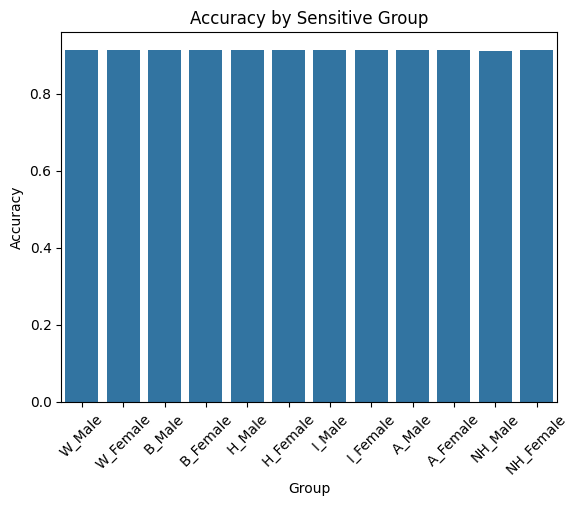

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

group_accuracies = {
    "Group": sensitive_features.columns,
    "Accuracy": [0.9141, 0.9141, 0.9141, 0.9141, 0.9141, 0.9141, 0.9141, 0.9140, 0.9137, 0.9139, 0.9103, 0.9133]
}

df_accuracies = pd.DataFrame(group_accuracies)
sns.barplot(data=df_accuracies, x="Group", y="Accuracy")
plt.xticks(rotation=45)
plt.title("Accuracy by Sensitive Group")
plt.show()

In [18]:
for group in sensitive_features.columns:
    print(f"{group}: {A_test[group].sum()} samples, "
          f"Risk_Cat distribution: {y_test[A_test[group] > 0].value_counts(normalize=True)}")


W_Male: 9575.499167638922 samples, Risk_Cat distribution: Risk_Cat
Below Average    0.343584
Above Average    0.341463
High             0.137858
Low              0.129374
Very low         0.026511
Very high        0.021209
Name: proportion, dtype: float64
W_Female: 9572.141952416483 samples, Risk_Cat distribution: Risk_Cat
Below Average    0.343584
Above Average    0.341463
High             0.137858
Low              0.129374
Very low         0.026511
Very high        0.021209
Name: proportion, dtype: float64
B_Male: 6733.346509889049 samples, Risk_Cat distribution: Risk_Cat
Below Average    0.343584
Above Average    0.341463
High             0.137858
Low              0.129374
Very low         0.026511
Very high        0.021209
Name: proportion, dtype: float64
B_Female: 6513.379668538617 samples, Risk_Cat distribution: Risk_Cat
Below Average    0.343584
Above Average    0.341463
High             0.137858
Low              0.129374
Very low         0.026511
Very high        0.021209
Name:

In [16]:
from sklearn.metrics import confusion_matrix

for group in sensitive_features.columns:
    group_mask = A_test[group] > 0
    conf_matrix = confusion_matrix(y_test[group_mask], y_pred[group_mask])
    
    # Check dimensions of the confusion matrix to avoid unpacking issues
    if conf_matrix.shape == (2, 2):
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        tn = fp = fn = tp = 0  # Default fallback if the matrix isn't 2x2
    
    print(f"{group} - TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")


W_Male - TN: 0, FP: 0, FN: 0, TP: 0
W_Female - TN: 0, FP: 0, FN: 0, TP: 0
B_Male - TN: 0, FP: 0, FN: 0, TP: 0
B_Female - TN: 0, FP: 0, FN: 0, TP: 0
H_Male - TN: 0, FP: 0, FN: 0, TP: 0
H_Female - TN: 0, FP: 0, FN: 0, TP: 0
I_Male - TN: 0, FP: 0, FN: 0, TP: 0
I_Female - TN: 0, FP: 0, FN: 0, TP: 0
A_Male - TN: 0, FP: 0, FN: 0, TP: 0
A_Female - TN: 0, FP: 0, FN: 0, TP: 0
NH_Male - TN: 0, FP: 0, FN: 0, TP: 0
NH_Female - TN: 0, FP: 0, FN: 0, TP: 0
